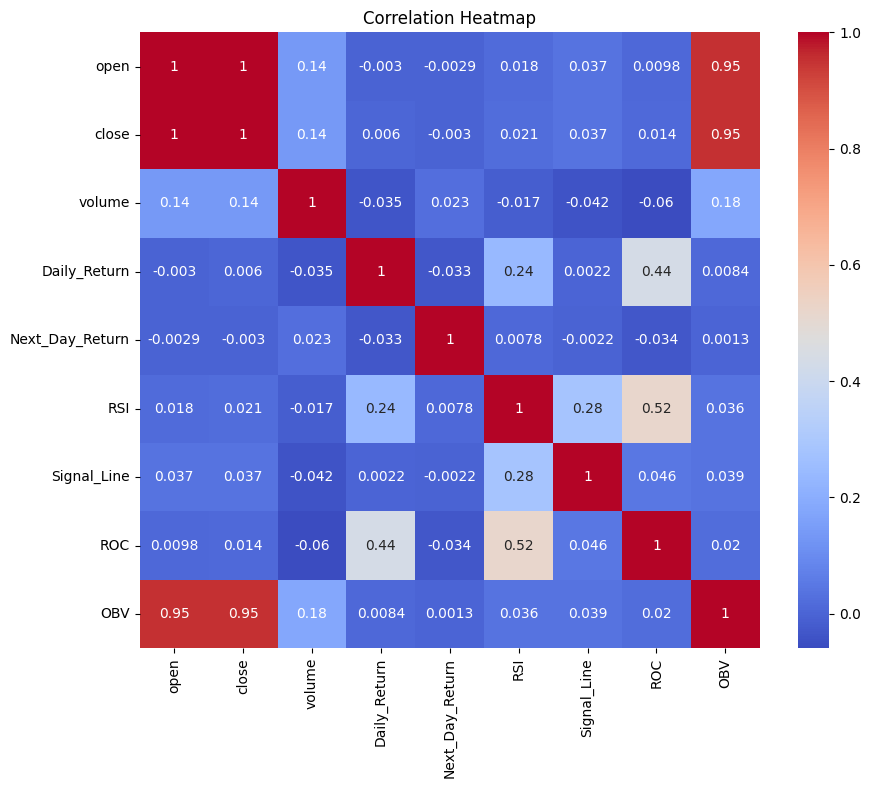

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_file(filename):
    return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)

def get_data(timeframe):
    return read_file("../../data/btcusdt_" + timeframe + ".csv")

time_frame = "1h"
# Load data
df = get_data(time_frame)
df.head()

df['Daily_Return'] = df['close'].pct_change()
df['Next_Day_Return'] = df['Daily_Return'].shift(-1)
window = 14
delta = df['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))
short_window = 12
long_window = 26
signal_window = 9
df['Short_MA'] = df['close'].rolling(window=short_window).mean()
df['Long_MA'] = df['close'].rolling(window=long_window).mean()
df['MACD'] = df['Short_MA'] - df['Long_MA']
df['Signal_Line'] = df['MACD'].rolling(window=signal_window).mean()
n = 5
df['ROC'] = df['close'].pct_change(n) * 100
df['OBV'] = np.where(df['close'] > df['close'].shift(1), df['volume'], -df['volume'])
df['OBV'] = df['OBV'].cumsum()
df_ = df.drop(['high', 'low', 'MACD', 'Short_MA', 'Long_MA'], axis=1)
df_ = df_.drop(df_.index[:50])
df_ = df_.dropna()

df_.head()

# Calculate the correlation matrix
correlation_matrix = df_.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
df_.to_csv("../logs/junk" + time_frame + ".csv")

In [2]:
from sklearn.linear_model import LinearRegression
# Import the necessary libraries

# Create the linear regression model
model = LinearRegression()

# Define the independent variables
X = df_.drop('Next_Day_Return', axis=1)
X = X.drop('open', axis=1)
print(X.columns)

# Define the dependent variable
y = df_['Next_Day_Return']



df_['indicator'] = 0

# Fit the linear regression model on the entire data
print(X.shape, y.shape  )
model.fit(X, y)
y_pred = model.predict(X)
df_['indicator'] = 2*(y_pred > 0).astype(int) - 1

data = df_
tot = 0
for index, _ in data.iterrows():
    data.at[index, 'signal'] = 0
    if data.at[index, 'indicator'] == 1:
        if tot == 0 or tot == -1:
            # enter long position/exit short position
            tot += 1
            data.at[index, 'signal'] = 1
    elif data.at[index, 'indicator'] == -1:
        if tot == 0 or tot == 1:
            # enter short position/exit long position
            tot -= 1
            data.at[index, 'signal'] = -1
    else:
        if tot == 1:
            # exit long position
            data.at[index, 'signal'] = -1
        elif tot == -1:
            # exit short position
            data.at[index, 'signal'] = 1
        tot = 0

data.to_csv("../logs/lin_reg_" + time_frame + ".csv")

Index(['close', 'volume', 'Daily_Return', 'RSI', 'Signal_Line', 'ROC', 'OBV'], dtype='object')
(35157, 7) (35157,)


In [3]:
print(model.coef_)

[-1.75041864e-08  7.62909715e-08 -2.33710195e-02  1.97959395e-05
 -2.73287666e-07 -1.95862065e-04  8.34036354e-10]
